In [1]:
from BinaryFileUnpack import BinaryFileUnpack
import numpy as np
import tkinter as tk
from tkinter import filedialog
from matplotlib import pyplot as plt

Initializing BinaryFileUnpack object

In [2]:
# Select the file to analyze
interactive_select = True

if interactive_select :
    root = tk.Tk()
    root.withdraw()
    filepath = filedialog.askopenfilename()
else:
    filepath = r'HotWaterCycles_heaters_on_steam_in-20221118-20-09-42.bin'
print(filepath)

D:/2023/07-05/calibration_water_SN5122770_20p7cm-20230705-14-38-19.bin


Forming Spectral Analysis

In [3]:
# Replace fp with necessary path
analysis = BinaryFileUnpack(filepath)
num_sens = analysis.num_sens
analysis.header_info

{'File Version': 3,
 'Sampling Rate': 1000.0,
 'Device Count': 3,
 'Device ID': array([0, 1, 2]),
 'Serial Number Length': array([7, 7, 7], dtype=uint32),
 'Serial Number': array([[53, 57, 53, 52, 56, 55, 56],
        [53, 57, 53, 52, 56, 55, 54],
        [53, 57, 53, 52, 56, 55, 55]]),
 'Name Length': array([7, 7, 7], dtype=uint32),
 'Name': array([[ 76,  97,  98,  65, 109, 112,  49],
        [ 76,  97,  98,  65, 109, 112,  50],
        [ 76,  97,  98,  65, 109, 112,  51]]),
 'Number of Enabled Channels': array([4, 4, 4], dtype=uint32),
 'Channel Number': array([[1, 2, 3, 4],
        [1, 2, 3, 4],
        [1, 2, 3, 4]])}

In [4]:
# Pressure
Pxx = analysis.spectra(analysis.P)
# Temperature
Txx = analysis.spectra(analysis.T)

Graphing in Matplotlib (static)

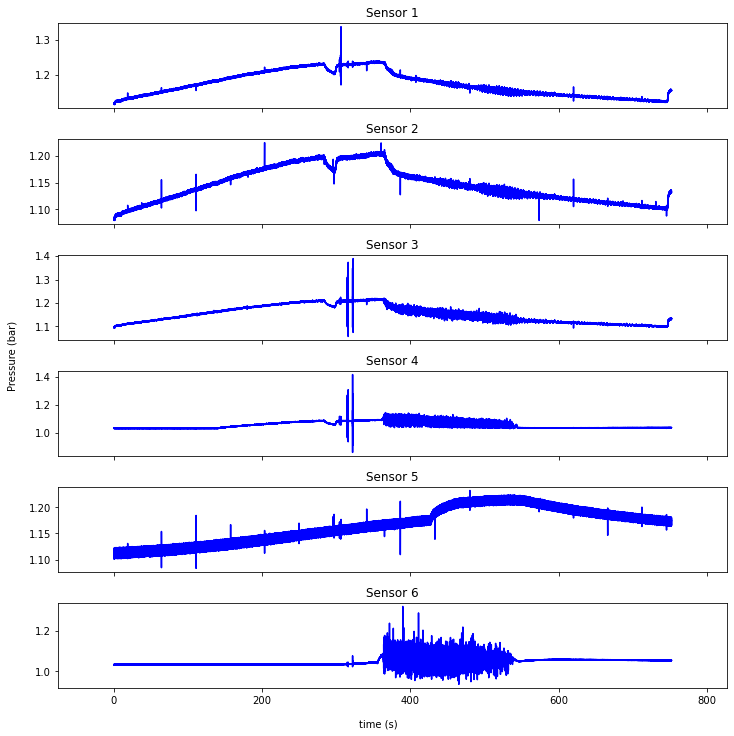

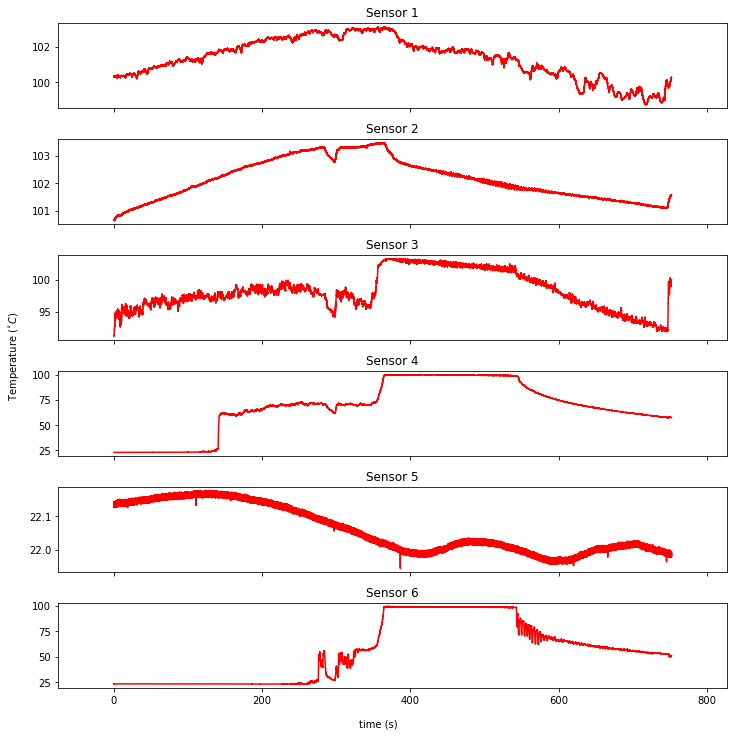

In [29]:
sta = 0; end = len(analysis.time)/analysis.fs

# Pressure and Temperature Data
analysis.plot_static(analysis.time, analysis.P, "time (s)", "Pressure (bar)", plots_shape=(num_sens, 1), color='b')
analysis.plot_static(analysis.time, analysis.T, "time (s)", r"Temperature ($^{\circ}C$)", plots_shape=(num_sens, 1), color='r')

# Spectral Analysis
analysis.plot_static(Pxx[0], Pxx[1], "Frequency (Hz)", "Power (dB)", plots_shape=(num_sens//2, 2), color='b', x_axis_type='log')
analysis.plot_static(Txx[0], Txx[1], "Frequency (Hz)", "Power (dB)", plots_shape=(num_sens//2, 2), color='r', x_axis_type='log')

Graphing in Bokeh (Interactive)

In [28]:
# Pressure and Temperature Data
res = 1
analysis.plot_interactive(analysis.time[::res], analysis.P[:, ::res], "Time (s)", "Pressure (bar)", (num_sens, 1), color='blue')
analysis.plot_interactive(analysis.time[::res], analysis.T[:, ::res], "Time (s)", "Temperature (deg C)", (num_sens, 1), color='red')

# Spectral Analysis
analysis.plot_interactive(Pxx[0, :, :], Pxx[1, :, :], "Frequency (Hz)", "Power (dB)-Pressure", plots_shape=(num_sens//2, 2), color='blue', x_axis_type='log')
analysis.plot_interactive(Txx[0, :, ::res], Txx[1, :, ::res], "Frequency (Hz)", "Power (dB)-Temperature", plots_shape=(num_sens//2, 2), color='red', x_axis_type='log')

Plotting Pressure against Temperature Data for Hot Water Eruption Cycles

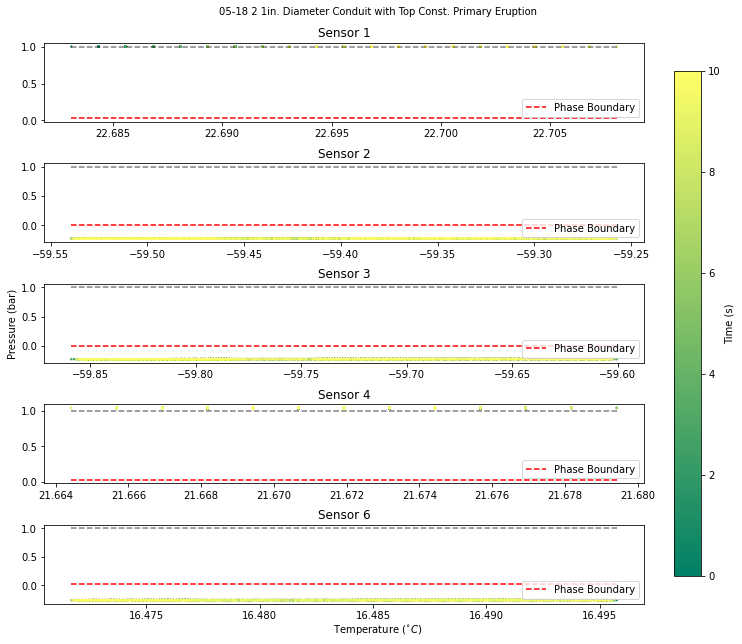

In [4]:
analysis.plot_eruption_PT(show_phase_boundaries=True, title="05-18 2 1in. Diameter Conduit with Top Const. Primary Eruption", ordering=[0, 1, 2, 3, 5], savefig=False)